# 说明
+ ex3data1.mat - Training set of hand-written digits

+ ex3weights.mat - Initial weights for the neural network exercise

# 导入包

In [86]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import scipy.io as io

base = "/content/drive/MyDrive/Colab Notebooks/AndrewNg-Machine-Learning-Homework/ex3-Nerual-Networks"

# Logistic回归的多分类问题

## 导入数据

In [87]:
data_path = base + "/ex3data1.mat"
weights_path = base + "/ex3weights.mat"

data = io.loadmat(data_path)
weights = io.loadmat(weights_path)

X = data['X'] # 5000个样本，每个样本都为20*20的灰色图像
y = data['y'] # 图片对应的数字识别
print(X, y)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] [[10]
 [10]
 [10]
 ...
 [ 9]
 [ 9]
 [ 9]]


## 数据可视化

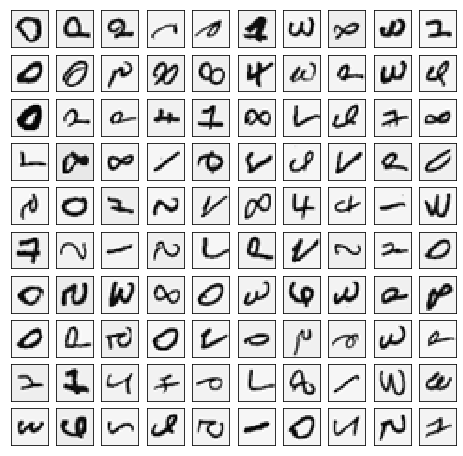

In [53]:
def DataVisualizing(X):
  index = np.random.choice(range(5000), 100) # 从0-4999中选100个数
  images = X[index]
  # sharey,sharex为共享xy轴，则所有小图都为一个大小
  # 设置10,10为设置大图排列为10*10，小图大小由总图大小figsize=(8,8)等分100份
  fig, ax = plt.subplots(10, 10, sharey=True, sharex=True, figsize=(8,8))
  for r in range(10):
    for c in range(10):
      # 图中rc位置，以gray_r的形式显示图片images[...]
      ax[r, c].matshow(images[r * 10 + c].reshape([20, 20]), cmap='gray_r')
  # 把横纵坐标跨度设为空
  plt.xticks([])
  plt.yticks([])
  plt.show()

DataVisualizing(X)

## 数据集处理


将y中的10改为0

In [90]:
for i in range(y.shape[0]):
  if y[i] == 10:
    y[i] = 0

[[0]
 [0]
 [0]
 ...
 [9]
 [9]
 [9]]


将数据集改为对应二分类的形式

In [154]:
# 一口气将十个分类器的标签改好
y_trans = np.matrix(np.zeros([y.shape[0], 10])) # m*10 即m*K
for k in range(10):
  temp = np.copy(y)
  for i in range(y.shape[0]):
    temp[i] = 1 if y[i] == k else 0
  y_trans[:, k] = temp

# 获取第k个分类器的标签
def DatasetProcess(y, k):
  y_process = y_trans[:, k]

  return y_process

给X添加一列

In [92]:
X = np.insert(X, 0, values=1, axis=1)

## Sigmoid函数

In [93]:
def sigmoid(z):
  return 1 / (1 + np.exp(-z))

## 假设函数
共计有K个类别

***
例如：“0”的分类器
$\left\{\begin{matrix}
正样本：y^{(i)}=0
 \\
负样本：y^{(i)}\ne0
\end{matrix}\right. \Rightarrow y^0$

$h^{(0)}(\theta)=\sigma (X\theta^{(0)})$

其中：$X$为m×(n+1)维，$\theta^{(0)}$为(n+1)×1维，$h^{(0)}$为m×1维
***
k类别的通式：对于k的分类器
$\left\{\begin{matrix}
正样本：y^{(i)}=k
 \\
负样本：y^{(i)}\ne k
\end{matrix}\right. \Rightarrow y^k$

$h^{(k)}(\theta)=\sigma (X\theta^{(k)})$

其中：$X$为m×(n+1)维，$\theta^{(k)}$为(n+1)×1维，$h^{(k)}$为m×1维。

***
实现公式：
$\Theta=\begin{bmatrix}
\theta^{(0)}  & \theta^{(1)} & ... & \theta^{(K-1)}
\end{bmatrix}_{(n+1)\times K}$

则有
$H(X)=\begin{bmatrix}h^{(0)}(X)  & h^{(1)}(X) & ... & h^{(K-1)}(X)\end{bmatrix}_{m\times K}=\sigma(X\Theta)$

其中：$X$为m×(n+1)维，$\Theta$维(n+1)×K维，$H(x)$为m×K维。

In [94]:
def Hypothesis(X, theta):
  # X：m*(n+1)维
  # theta：(n+1)*1维
  return sigmoid(X @ theta)

## 代价函数
公式：
$$J(\theta)=\frac{1}{m}\sum_{i=1}^m[-y^{(i)}\log(h_\theta(x^{(i)}))-(1-y^{(i)})\log(1-h_\theta(x^{(i)}))]$$

***
例如：“0”的分类器
$$
J(\theta^{(0)})
=\frac{1}{m}\sum_{i=1}^m[-y^{(i)}\log(h^{(0)}_\theta(x^{(i)}))-(1-y^{(i)})\log(1-h^{(0)}_\theta(x^{(i)}))]
=-\frac{1}{m}[(y^0)^T\log(h^{(0)}_\theta(X))+(1-y^0)^T\log(1-h^{(0)}_\theta(X))]$$

***
实现公式：
“k”的分类器
$$
J(\theta^{(k)})
=-\frac{1}{m}[(y^k)^T\log(h^{(k)}_\theta(X))+(1-y^k)^T\log(1-h^{(k)}_\theta(X))]$$

In [58]:
def ComputeCost(X, y, theta, k):
  # X：m*(n+1)维
  # y：m*1维
  # theta：(n+1)*1维
  # k：类别k的分类器
  y_process = DatasetProcess(y, k)

  m = y_process.shape[0]
  y_hat = Hypothesis(X, theta)
  
  cost = -1 * (y_process.T @ np.log(y_hat) + (1-y_process).T @ np.log(1-y_hat)) / m
  return cost

## 计算梯度
实现公式：

对于：“0”这一类
$$
\frac{\partial J(\theta^{(0)})}{\partial \theta^{(0)}}=\frac{1}{m}X^T(h^{(0)}_\theta(X)-y^0)
$$

通式：“k”这一类
$$
\frac{\partial J(\theta^{(k)})}{\partial \theta^{(k)}}=\frac{1}{m}X^T(h^{(k)}_\theta(X)-y^k)
$$


In [59]:
def ComputePartial(X, y, theta, k):
  # X：m*(n+1)维
  # y：m*1维
  # theta：(n+1)*1维
  # k：类别k的分类器
  y_process = DatasetProcess(y, k)

  m = y_process.shape[0]
  y_hat = Hypothesis(X, theta)

  partial = (X.T @ (y_hat - y_process)) / m
  return partial

## 梯度下降

In [60]:
def GradientDescent(X, y, theta, k, Iterations, LearningRate):
  cost = np.zeros(Iterations)
  for i in range(Iterations):
    theta = theta - LearningRate * ComputePartial(X, y, theta, k)
    cost[i] = ComputeCost(X, y, theta, k)
  return theta, cost 

## 运行梯度下降

In [127]:
Iterations = 1000
LearningRate = 0.5
K = 10 # 分类数

theta = np.matrix(np.zeros([X.shape[1], K]))
cost = np.matrix(np.zeros([K, Iterations]))

# theta[:, 0], cost[0, :] = GradientDescent(X, y, theta[:, 0], 0, Iterations, LearningRate)
for k in range(K):
  theta[:, k], cost[k, :] = GradientDescent(X, y, theta[:, k], k, Iterations, LearningRate)

## 绘制代价曲线（单个）

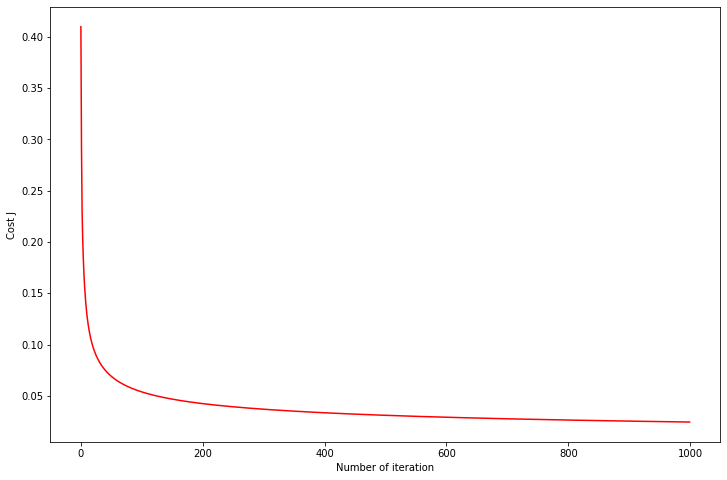

In [128]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(np.arange(Iterations), cost[0, :].T, 'r')
ax.set_xlabel("Number of iteration")
ax.set_ylabel("Cost J")
plt.show()

## 绘制代价曲线（K个）

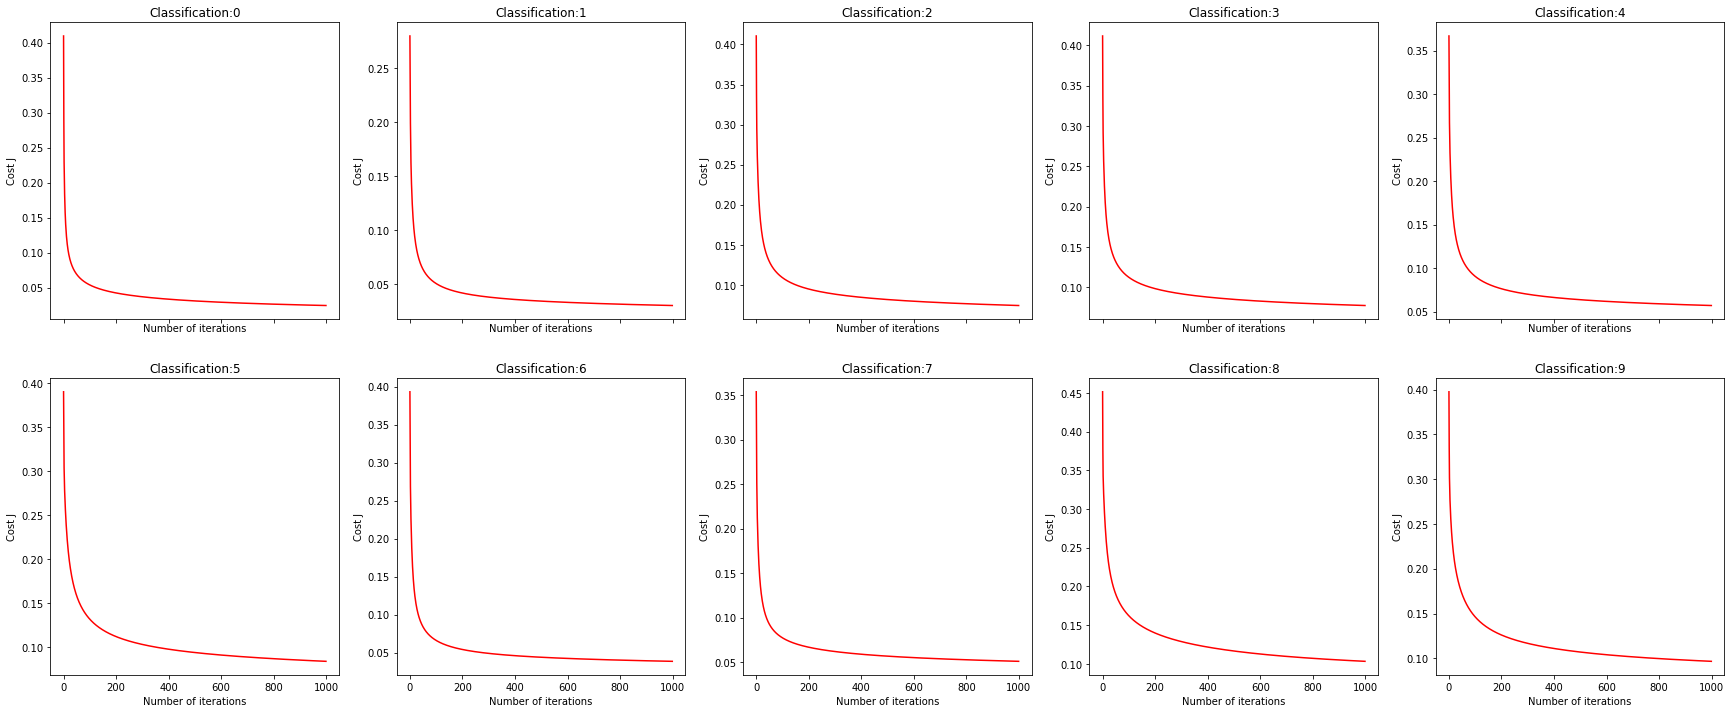

In [129]:
fig, ax = plt.subplots(2, 5, sharex=True, figsize=(30, 12))
for r in range(2):
  for c in range(5):
    ax[r, c].plot(np.arange(Iterations), cost[r*5+c].T, 'r')
    ax[r, c].set_xlabel("Number of iterations")
    ax[r, c].set_ylabel("Cost J")
    ax[r, c].set_title("Classification:%d"%(r*5+c))
plt.show()

## 多分类结果显示



### 输入单个样本检测，显示K个类别的检测结果

In [105]:
def OneVsAll(x, y, theta):
  ret = np.matrix(np.zeros(K)).T
  for k in range(K):
    ret[k] = Hypothesis(x, theta[:, k]) 
  print(ret)

  for k in range(K):
    ret[k] = 1 if ret[k] == np.max(ret) else 0
  print(ret)

OneVsAll(X[0, :], y, theta)

[[9.84561948e-01]
 [1.99314781e-04]
 [3.15352042e-03]
 [6.45227897e-03]
 [2.12601758e-04]
 [3.93022174e-02]
 [6.20574819e-03]
 [4.70073375e-03]
 [3.50438151e-03]
 [6.14816514e-03]]
[[1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


### 输入多个样本，检测出识别出来得是什么数字

In [143]:
def Classification(X, y, theta):
  y_clas = np.matrix(np.zeros(X.shape[0])).T
  for i in range(X.shape[0]):
    temp = np.matrix(np.zeros(K)).T # 暂存K个类别的判别评分
    mmax = 0 # 记录最大值的下标
    for k in range(K):
      temp[k] = Hypothesis(X[i, :], theta[:, k]) 
      if temp[mmax] < temp[k]:
        mmax = k
    y_clas[i] = mmax
  return y_clas

## 计算Accuracy
公式：
$$Accuracy = \frac{Prediction\ Right}{Total}$$

In [144]:
# 前置运行Classification函数
def ComputeAccuracy(X, y, theta):
  y_clas = Classification(X, y, theta)
  right = 0
  for i in range(y_clas.shape[0]):
    right = right + (1 if y_clas[i] == y[i] else 0)
  accuracy = right / y_clas.shape[0]
  return accuracy
  
accuracy = ComputeAccuracy(X, y, theta)
print("Accuracy：", accuracy)

Accuracy： 0.9214


# 正则化的Logistic回归的多分类问题

## 正则化的代价函数
公式：
$$J(\theta)=\frac{1}{m}\sum_{i=1}^m[-y^{(i)}\log(h_\theta(x^{(i)}))-(1-y^{(i)})\log(1-h_\theta(x^{(i)}))]+\frac{\lambda}{2m}\sum_{j=1}^n\theta_j^2$$

***
例如：“0”的分类器
$$
J(\theta^{(0)})
=\frac{1}{m}\sum_{i=1}^m[-y^{(i)}\log(h^{(0)}_\theta(x^{(i)}))-(1-y^{(i)})\log(1-h^{(0)}_\theta(x^{(i)}))]+\frac{\lambda}{2m}\sum_{j=1}^n\theta_j^2
=-\frac{1}{m}[(y^0)^T\log(h^{(0)}_\theta(X))+(1-y^0)^T\log(1-h^{(0)}_\theta(X))]+\frac{\lambda}{2m}(\theta^{(0)}[1:,])^T\theta^{(0)}[1:,]$$

***
实现公式：
“k”的分类器
$$
J(\theta^{(k)})
=-\frac{1}{m}[(y^k)^T\log(h^{(k)}_\theta(X))+(1-y^k)^T\log(1-h^{(k)}_\theta(X))]+\frac{\lambda}{2m}(\theta^{(k)}[1:,])^T\theta^{(k)}[1:,]$$

In [136]:
def ComputeCostReg(X, y, theta, k, lambd):
  # X：m*(n+1)维
  # y：m*1维
  # theta：(n+1)*1维
  # k：类别k的分类器
  # lambd：正则化参数
  y_process = DatasetProcess(y, k)

  m = y_process.shape[0]
  y_hat = Hypothesis(X, theta)
  
  cost = -1 * (y_process.T @ np.log(y_hat) + (1-y_process).T @ np.log(1-y_hat)) / m + lambd / (2*m) * (theta[1:, ].T @ theta[1:, ])
  return cost

## 正则化的梯度计算
公式：

例如：“0”的分类器

if j == 0:
$$
\frac{\partial J(\theta)}{\partial \theta^{(0)}_j}
=\frac{1}{m}\sum_{i=1}^m[h_\theta^{(0)}(x^{(i)})-y^0]x^{(i)}_j
=\frac{1}{m}(x_j)^T[h_\theta^{(0)}(X)-y^0]
$$

if j != 0:
$$
\frac{\partial J(\theta)}{\partial \theta^{(0)}_j}
=\frac{1}{m}\sum_{i=1}^m[h_\theta^{(0)}(x^{(i)})-y^0]x^{(i)}_j+\frac{\lambda}{m}
$$

向量化：
$$
\frac{\partial J(\theta)}{\partial \Theta^{(0)}}
=\frac{1}{m}(X)^T[h_\theta^{(0)}(X)-y^0]+\frac{\lambda}{m}\Theta^{(0)}
$$
其中：$\Theta^{(0)}=\begin{bmatrix}
0 \\
\theta_1^{(0)} \\
\vdots \\
\theta_n^{(0)}
\end{bmatrix}_{(n+1)\times 1}$,$\frac{\partial J(\theta)}{\partial \Theta^{(0)}}$为(n+1)×1维。

***
实现公式：

通式：“k”这一类
$$
\frac{\partial J(\theta)}{\partial \Theta^{(k)}}
=\frac{1}{m}(X)^T[h_\theta^{(k)}(X)-y^k]+\frac{\lambda}{m}\Theta^{(k)}
$$
其中：$\Theta^{(k)}=\begin{bmatrix}
0 \\
\theta_1^{(k)} \\
\vdots \\
\theta_n^{(k)}
\end{bmatrix}_{(n+1)\times 1}$,$\frac{\partial J(\theta)}{\partial \Theta^{(0)}}$为(n+1)×1维。


In [137]:
def ComputePartialReg(X, y, theta, k, lambd):
  # X：m*(n+1)维
  # y：m*1维
  # theta：(n+1)*1维
  # k：类别k的分类器
  # lambd：正则化参数
  y_process = DatasetProcess(y, k)

  m = y_process.shape[0]
  y_hat = Hypothesis(X, theta)

  Theta = np.insert(theta[1:,], 0, values=0, axis=0)
  partial = (X.T @ (y_hat - y_process)) / m + lambd / m * Theta
  return partial

## 正则化的梯度下降

In [138]:
def GradientDescentReg(X, y, theta, k, lambd, Iterations, LearningRate):
  cost = np.zeros(Iterations)
  for i in range(Iterations):
    theta = theta - LearningRate * ComputePartialReg(X, y, theta, k, lambd)
    cost[i] = ComputeCostReg(X, y, theta, k, lambd)
  return theta, cost 

## 运行梯度下降

In [161]:
Iterations2 = 1000
LearningRate2 = 0.5
lambd = 10 # 正则化参数
K = 10 # 分类数

theta2 = np.matrix(np.zeros([X.shape[1], K]))
cost2 = np.matrix(np.zeros([K, Iterations2]))

for k in range(K):
  theta2[:, k], cost2[k, :] = GradientDescentReg(X, y, theta2[:, k], k, lambd, Iterations2, LearningRate2)

## 绘制代价曲线（K个）

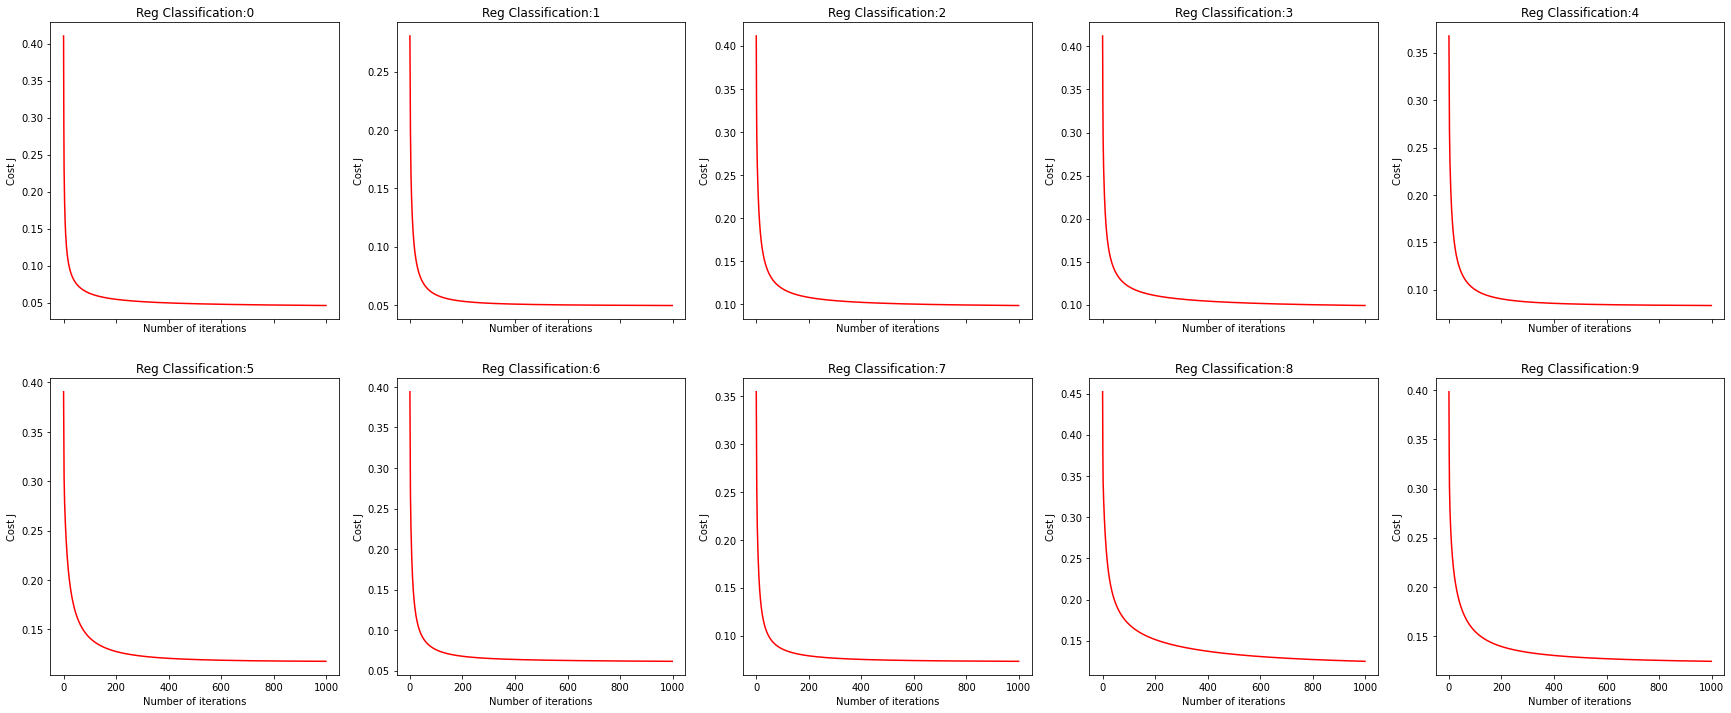

In [162]:
fig, ax = plt.subplots(2, 5, sharex=True, figsize=(30, 12))
for r in range(2):
  for c in range(5):
    ax[r, c].plot(np.arange(Iterations2), cost2[r*5+c].T, 'r')
    ax[r, c].set_xlabel("Number of iterations")
    ax[r, c].set_ylabel("Cost J")
    ax[r, c].set_title("Reg Classification:%d"%(r*5+c))
plt.show()

## 计算Accuracy
公式：
$$Accuracy = \frac{Prediction\ Right}{Total}$$

In [163]:
accuracy2 = ComputeAccuracy(X, y, theta2)
print("Accuracy：", accuracy2)

Accuracy： 0.9162
